In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
from matplotlib import patches, image
from matplotlib.ticker import FuncFormatter

from tqdm import tqdm
from time import sleep
from matplotlib import animation, rc
from IPython.display import HTML

from helpers import *

## Load fixations as % looking time

In [2]:
base_dir = os.path.realpath('../..')
print(base_dir)
sys.path.append('/'.join(os.path.realpath('..').split('/')[:4]) + '/Python')
import FigureTools

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study2_EyeTracking


In [3]:
desktopdir = '/Users/jeroen/Desktop'

In [4]:
eye = 'average'
fix_pct_LT = pd.read_csv(base_dir + 
                '/Data/all_fixations_as_pct_LT_eye-%s.csv'%eye,index_col=0)
fix_pct_LT.head()

,sub,part,block,player_type,trial,num,num_S_T,dur_pct
0,5,1,1.0,opt_nat,1,10_1,no_S_T,0.123562
1,5,1,1.0,opt_nat,1,10_2,no_S_T,0.113534
2,5,1,1.0,opt_nat,1,5_1,no_S_T,0.000000
3,5,1,1.0,opt_nat,1,5_2,no_S_T,0.000000
4,5,1,1.0,opt_nat,1,S_1,S,0.108974


## Plot by condition

##### Mean across blocks and trials, and sum across S_1/S_2 and T_1/T_2

In [5]:
tmp = fix_pct_LT.groupby(['sub','part','player_type','num_S_T','num']).mean().reset_index()
tmp = tmp[['sub','part','player_type','num_S_T','num','dur_pct']]
tmp = tmp.groupby(['sub','part','player_type','num_S_T'],
                          as_index=False).sum()
tmp.head()

,sub,part,player_type,num_S_T,dur_pct
0,5,1,opt_inv,S,0.171438
1,5,1,opt_inv,T,0.128132
2,5,1,opt_inv,no_S_T,0.700430
3,5,1,opt_nat,S,0.096319
4,5,1,opt_nat,T,0.131792


##### Plot

In [6]:
pts = ['opt_nat','pess_nat','opt_inv','pess_inv']

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


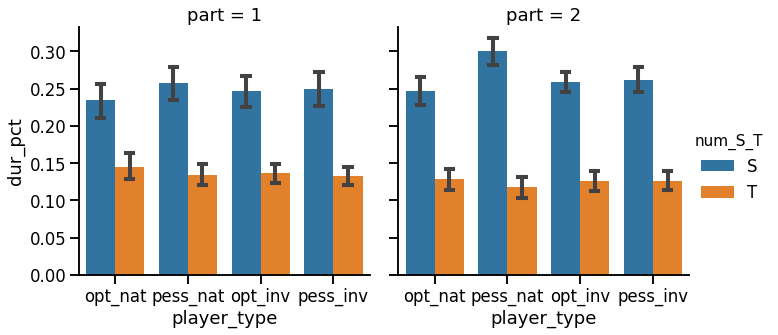

In [7]:
sns.set_context('talk')
sns.catplot(kind = 'bar', data = tmp,
            x = 'player_type', y = 'dur_pct', hue = 'num_S_T',
            order = pts, hue_order = ['S','T'],
            col = 'part', capsize = .1)

# Eye tracking results 1: gaze differences between Greedy and Risk-Averse block

Note: in line with some other literature (Poncela-Casasnovas SciAdv) Greedy is still called "Optimist" and Risk-Averse "Pessimist" here; terminology was aligned in the paper.

,sub,player_type,num_S_T,dur_pct
0,5,opt_inv,S,0.201654
1,5,opt_inv,T,0.107986
2,5,opt_inv,no_S_T,0.690360
3,5,opt_nat,S,0.159366
4,5,opt_nat,T,0.129862


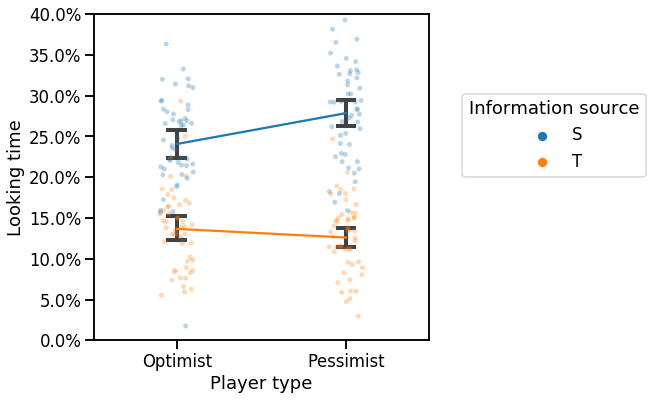

In [8]:
tmp = fix_pct_LT.groupby(['sub','player_type','num_S_T','num']).mean().reset_index()
tmp = tmp[['sub','player_type','num_S_T','num','dur_pct']]
tmp = tmp.groupby(['sub','player_type','num_S_T'],
                          as_index=False).sum()
display(tmp.head())

sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=[6,6])
sns.stripplot(data = tmp,
              x = 'player_type', y = 'dur_pct', hue = 'num_S_T',
            order = ['opt_nat','pess_nat'], hue_order = ['S','T'],
              dodge = False, alpha = .3, ax = ax)
hand,lab = ax.get_legend_handles_labels()
sns.barplot(data = tmp,
            x = 'player_type', y = 'dur_pct', hue = 'num_S_T',
            order = ['opt_nat','pess_nat'], hue_order = ['S','T'],
            capsize = .1, alpha = 0, dodge = False)
dat1 = tmp.query('player_type == "opt_nat" and num_S_T == "S"'
                )['dur_pct']
dat2 = tmp.query('player_type == "opt_nat" and num_S_T == "T"'
                )['dur_pct']
dat3 = tmp.query('player_type == "pess_nat" and num_S_T == "S"'
                )['dur_pct']
dat4 = tmp.query('player_type == "pess_nat" and num_S_T == "T"'
                )['dur_pct']
plt.plot([0,1],[np.mean(dat1),np.mean(dat3)])
plt.plot([0,1],[np.mean(dat2),np.mean(dat4)])
plt.legend(hand,lab,loc=[1.1,.5], title = 'Information source',
           facecolor = None)
ax.set(ylabel = 'Looking time', xlabel = 'Player type',
       xticklabels = ['Optimist','Pessimist'], 
       yticks = np.arange(0,.45,.05), ylim = [0,.4]);
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()]);

In [9]:
diff1 = dat3.values - dat1.values
diff2 = dat4.values - dat2.values

In [10]:
scipy.stats.ttest_rel(diff1,diff2)

Ttest_relResult(statistic=5.109179459452987, pvalue=5.314138868954674e-06)

# Eye tracking results 2: gaze differences between blocks developing over time (trials)

##### Split blocks in 2 halves and 4 mini-blocks

In [11]:
fix_pct_LT['block_trial'] = (fix_pct_LT['trial'] - 
                             np.floor(np.divide(fix_pct_LT['trial'],16.001))*16).astype(int)

fix_pct_LT['phase'] = fix_pct_LT['block_trial'].apply(lambda x: 'early' if x < 9 else 'late')

fix_pct_LT['mini_block'] = (np.floor((fix_pct_LT['block_trial']-1)/4)+1).astype(int)
fix_pct_LT.head()

,sub,part,block,player_type,trial,num,num_S_T,dur_pct,block_trial,phase,mini_block
0,5,1,1.0,opt_nat,1,10_1,no_S_T,0.123562,1,early,1
1,5,1,1.0,opt_nat,1,10_2,no_S_T,0.113534,1,early,1
2,5,1,1.0,opt_nat,1,5_1,no_S_T,0.000000,1,early,1
3,5,1,1.0,opt_nat,1,5_2,no_S_T,0.000000,1,early,1
4,5,1,1.0,opt_nat,1,S_1,S,0.108974,1,early,1


In [15]:
tmp = fix_pct_LT.groupby(['sub','player_type','mini_block','num_S_T','num']
                        ,as_index = False).mean().reset_index()
tmp = tmp.groupby(['sub','player_type','mini_block','num_S_T'],
                          as_index=False).sum()
display(tmp.head())

,sub,player_type,mini_block,num_S_T,index,part,block,trial,dur_pct,block_trial
0,5,opt_inv,1,S,1,3.0,11.0,149.0,0.216191,5.0
1,5,opt_inv,1,T,5,3.0,11.0,149.0,0.094784,5.0
2,5,opt_inv,1,no_S_T,30,7.5,27.5,372.5,0.689025,12.5
3,5,opt_inv,2,S,19,3.0,11.0,157.0,0.183557,13.0
4,5,opt_inv,2,T,23,3.0,11.0,157.0,0.116684,13.0


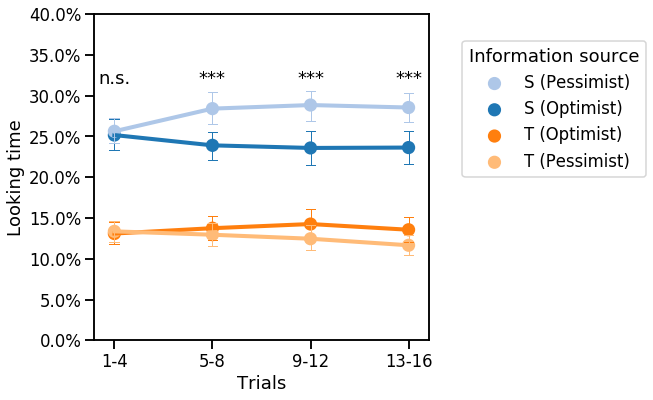

In [16]:
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=[6,6])
cols_1 = [sns.color_palette('tab20')[i] for i in [0,2]]
cols_2 = [sns.color_palette('tab20')[i] for i in [1,3]]
sns.pointplot(data = tmp.query('player_type == "opt_nat"'),
             x = 'mini_block', y = 'dur_pct', hue = 'num_S_T',
             ax = ax, hue_order = ['S','T'],
              capsize = .1, errwidth = 1,
             palette = cols_1, legend = 'off')
sns.pointplot(data = tmp.query('player_type == "pess_nat"'),
             x = 'mini_block', y = 'dur_pct', hue = 'num_S_T',
             ax = ax, hue_order = ['S','T'],
              capsize = .1, errwidth = 1,
             palette = cols_2, legend = 'off')
hand,lab = ax.get_legend_handles_labels()
plt.legend([hand[i] for i in [2,0,1,3]],
           ['S (Pessimist)','S (Optimist)',
            'T (Optimist)','T (Pessimist)'],
           loc=[1.1,.5], title = 'Information source',
          facecolor = None)
ax.set(ylabel = 'Looking time', xlabel = 'Trials',
       xticklabels = ['1-4','5-8','9-12','13-16'],
       yticks = np.arange(0,.45,.05), ylim = [0,.4]);
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()]);

y_starts = [.31,.17]
for isi,info_source in enumerate(['S']):
    for mbi,mini_block in enumerate(tmp['mini_block'].unique()):
#         print(info_source, mini_block)
        dat1 = tmp.query('num_S_T == @info_source & mini_block == @mini_block & player_type == "opt_nat"')['dur_pct']
        dat2 = tmp.query('num_S_T == @info_source & mini_block == @mini_block & player_type == "pess_nat"')['dur_pct']
        stats = scipy.stats.ttest_rel(dat1, dat2)
#         if stats[1] < (0.05/8):
        FigureTools.add_sig_markers(ax,
                relationships=[[mbi,mbi,stats[1]*4]],
                ystart = y_starts[isi], caps=False)#, distScale = .6)

Note to code: See LMER/LMER_LT_onto_mini-block_player-type_Risk.Rmd for R code analyzing this change in differences over time using mixed-effects regression.

# Eye tracking results 3: linking gaze shift to performance

In [41]:
# Compute average looking time difference per trial per subject
LT_diff_by_trial = fix_pct_LT.pivot_table(
    index = ['sub','trial','mini_block','player_type'],
    columns = ['num_S_T'], values = 'dur_pct').reset_index()
LT_diff_by_trial['S-T'] = LT_diff_by_trial['S'] - LT_diff_by_trial['T']

In [42]:
# Load game performance for each subject
game_dat = pd.read_csv('%s/Data/gameDat_study2.csv'%base_dir, index_col = 0,
                      dtype = {'sub':int})
game_dat['trial'] = game_dat['Trial'] + 1 + game_dat['Block']*16
game_dat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,GameType,Colors,CorrAns,GivenAns,ConfidenceNum,ScoreNum,RT_radio,RT_submit,SelfReport,trial
0,5,5005,0,N.N.,opt,nat,opt_nat,0,0,12,PD,"['Not', 'Defined']",def,def,86,1,8631,10443,not defined,1
1,5,5005,0,N.N.,opt,nat,opt_nat,1,7,5,HG,"['Not', 'Defined']",coop,coop,70,1,3639,5183,not defined,2
2,5,5005,0,N.N.,opt,nat,opt_nat,2,10,12,SG,"['Not', 'Defined']",def,coop,52,0,4796,6608,not defined,3
3,5,5005,0,N.N.,opt,nat,opt_nat,3,3,5,SH,"['Not', 'Defined']",coop,def,52,0,3840,5502,not defined,4
4,5,5005,0,N.N.,opt,nat,opt_nat,4,0,8,SH,"['Not', 'Defined']",coop,coop,54,1,3806,6322,not defined,5


In [43]:
# Add in total game score per subject, average per subject
tmp = LT_diff_by_trial[['sub','trial','player_type','S-T']].merge(
    game_dat[['sub','trial','ScoreNum']], on = ['sub','trial'])
tmp = tmp.groupby(['sub','player_type'],
                as_index=False).mean()
tmp = tmp.rename(columns={'ScoreNum':'score'})
display(tmp.head())

,sub,player_type,trial,S-T,score
0,5,opt_inv,80.5,0.046834,0.40625
1,5,opt_nat,40.5,0.014752,0.90625
2,5,pess_inv,80.5,0.032518,0.43750
3,5,pess_nat,56.5,0.054629,0.93750
4,6,opt_inv,80.5,0.098905,0.40625


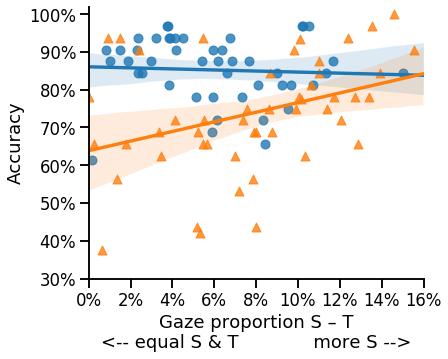

In [44]:
# Plot relationship
sns.set_context('talk')
pts = ['opt_nat','pess_nat']
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows,ncols,figsize=[6,5])
hands = dict()
labs = dict()
markers = ['o','^']
ax = axes
xticks = np.arange(0,.161,.02)
for pti,pt in enumerate(pts):
    sns.regplot(data = tmp.query('player_type == @pt'),
        x = 'S-T', y = 'score', ax = ax,
        label = pt, color = sns.color_palette('tab10')[pti],
        marker = markers[pti])
    hands,labs = ax.get_legend_handles_labels()
    ax.set(xlabel = 'Gaze proportion S – T\n<-- equal S & T             more S -->',
          ylabel = 'Accuracy', ylim = [0.3,1.02],
           xlim = [0,.16],
          xticks = xticks,
           xticklabels = ['{:,.0%}'.format(x) for x in xticks],
          yticks = np.arange(0.3,1.01,.1),
          yticklabels = ['{:,.0%}'.format(x) for x in  np.arange(0.3,1.01,.1)])
sns.despine(top=True, right = True)

In [45]:
# Statistics
# Optimist
statdat = tmp.query('player_type == "opt_nat"')
dat1 = statdat['S-T']
dat2 = statdat['score']
print(scipy.stats.pearsonr(dat1,dat2))
# Pessimist
statdat = tmp.query('player_type == "pess_nat"')
dat1 = statdat['S-T']
dat2 = statdat['score']
print(scipy.stats.pearsonr(dat1,dat2))

(-0.06964591347908644, 0.6308013347416787)
(0.36965178086723377, 0.008241238343605817)


# Supplementary Results 7: comparing gaze between participants with different mental models

In [46]:
# Load model features per subject, add these into the looking time data
bestPerSubject_features = pd.read_csv(base_dir+
    '/Data/Model_results/ModelFeaturesPerSubject.csv',index_col = 0)
bestPerSubject_features['sub'] = bestPerSubject_features['subID'] - 5000
fix_pct_LT_model_features = fix_pct_LT.merge(bestPerSubject_features, on = 'sub')

In [47]:
tmp = fix_pct_LT_model_features.groupby(['sub','Risk','player_type','num_S_T','num']
                        ,as_index = False).mean().reset_index()
tmp = tmp.groupby(['sub','Risk','player_type','num_S_T'],
                          as_index=False).sum()
display(tmp.head())

,sub,Risk,player_type,num_S_T,index,part,block,trial,dur_pct,block_trial,mini_block,subID,Coop,Greed,Nash,comb,BIC
0,5,True,opt_inv,S,1,3.0,11.0,161.0,0.201654,17.0,5.0,10010.0,0.0,2.0,0.0,22000.0,35.54
1,5,True,opt_inv,T,5,3.0,11.0,161.0,0.107986,17.0,5.0,10010.0,0.0,2.0,0.0,22000.0,35.54
2,5,True,opt_inv,no_S_T,30,7.5,27.5,402.5,0.690360,42.5,12.5,25025.0,0.0,5.0,0.0,55000.0,88.85
3,5,True,opt_nat,S,19,3.0,6.0,81.0,0.159366,17.0,5.0,10010.0,0.0,2.0,0.0,22000.0,35.54
4,5,True,opt_nat,T,23,3.0,6.0,81.0,0.129862,17.0,5.0,10010.0,0.0,2.0,0.0,22000.0,35.54


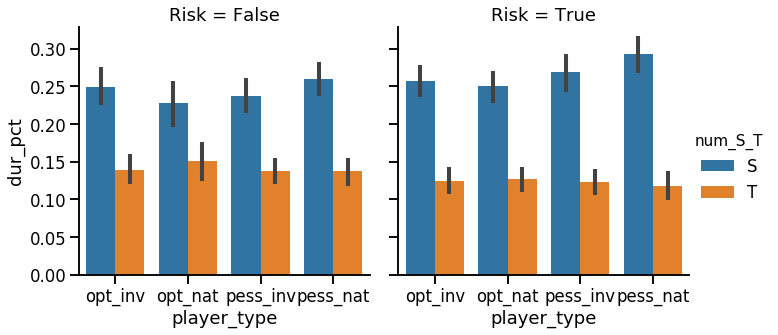

In [48]:
sns.catplot(data = tmp, kind = 'bar',
            x = 'player_type', y = 'dur_pct', hue = 'num_S_T',
            hue_order = ['S','T'],
            col = 'Risk')

##### Is the difference between looking at S and T across all blocks greater for people who consider Risk?

In [61]:
LT_diff_by_trial = fix_pct_LT_model_features.pivot_table(
    index = ['sub','Risk','trial','mini_block','player_type'],
    columns = ['num_S_T'], values = 'dur_pct').reset_index()
LT_diff_by_trial['S-T'] = LT_diff_by_trial['S'] - LT_diff_by_trial['T']
LT_diff_by_trial.head()

num_S_T,sub,Risk,trial,mini_block,player_type,S,T,no_S_T,S-T
0,5,True,1,1,opt_nat,0.054487,0.081152,0.145744,-0.026665
1,5,True,2,1,opt_nat,0.036582,0.024162,0.175702,0.012420
2,5,True,3,1,opt_nat,0.020697,0.000000,0.191721,0.020697
3,5,True,4,1,opt_nat,0.069122,0.038464,0.156966,0.030658
4,5,True,5,2,opt_nat,0.064392,0.077634,0.143189,-0.013242


In [62]:
diff_by_Risk = LT_diff_by_trial.groupby('sub',as_index=False).mean()[['Risk','S-T']].copy()
scipy.stats.ttest_ind(diff_by_Risk.loc[diff_by_Risk['Risk']==True,'S-T'],
                     diff_by_Risk.loc[diff_by_Risk['Risk']==False,'S-T'])

Ttest_indResult(statistic=2.0390522348356015, pvalue=0.04697174039559627)

# Figure 4B

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


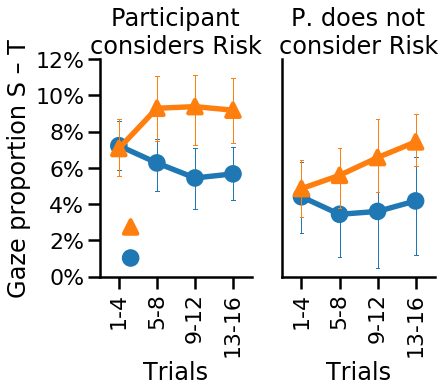

In [67]:
#### 1
sns.set_context('poster')
fig, ax = plt.subplots(1,2,figsize=[6,4], sharey=False)

# no risk
sns.pointplot(data = LT_diff_by_trial.query('Risk == True').groupby(
    ['sub','player_type','mini_block'], as_index=False).mean(),
              x = 'mini_block', hue = 'player_type', y = 'S-T',
              hue_order = ['opt_nat','pess_nat'],
              ax = ax[0], capsize = .1, errwidth = 1,
             markers = ['o','^'])

ax[0].set(ylabel = 'Gaze proportion S – T', xlabel = 'Trials',
       xticklabels = ['1-4','5-8','9-12','13-16'],
       yticks = np.arange(0,.121,.02), ylim = [0,.12],
       title = 'Participant\nconsiders Risk');
ax[0].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0].get_yticks()]);

hand,lab = ax[0].get_legend_handles_labels()
lab = ['Optimist', 'Pessimist']
ax[0].legend([hand[i] for i in [1,0]],
             ['',''],
             loc = [0,0], ncol=1, title = None,
            frameon=False)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)

# yes risk
sns.pointplot(data = LT_diff_by_trial.query('Risk == False').groupby(
    ['sub','player_type','mini_block'], as_index=False).mean(),
              x = 'mini_block', hue = 'player_type', y = 'S-T',
              hue_order = ['opt_nat','pess_nat'],
              ax = ax[1], capsize = .1, errwidth = 1, legend = False,
             markers = ['o','^'])

ax[1].set(xlabel = 'Trials', ylabel = None, yticks = [], ylim = [0,.12],
       xticklabels = ['1-4','5-8','9-12','13-16'],
       title = 'P. does not\nconsider Risk');
ax[1].get_legend().remove()
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90);

sns.despine(top=True, right = True)